# K-Means Clustering

The final goal of the code file is to build a system that recommends scientific papers (research papers) based on content similarity. Specifically:

How the Code Works
* Data Preparation:
The dataset is loaded and a new column text is created by concatenating the title and abstract. Universal Sentence Encoder (USE) is used to generate "use_embeddings.csv" file. However, my team already generated "use_embeddings.csv" file, so I can reuse it.

* Optimal Cluster Selection:
The code runs K-means clustering for a range of cluster counts (2 to 10). It computes:

* WCSS (Elbow Method): To show how the within-cluster variance decreases.
Silhouette Score: To measure the quality of the clusters. The optimal number is chosen as the one with the highest silhouette score.
* Clustering and Recommendation:
With the optimal number of clusters, the dataset is clustered. An input query is vectorized, its cluster is identified, and within that cluster, the five closest papers (by Euclidean distance) are selected.
* Their cosine similarity with the query is also computed to provide an additional evaluation metric.





In [1]:
from google.colab import drive
drive.mount('/content/drive')
# pip install tensorflow tensorflow-hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import TfidfVectorizer # Removed
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import tensorflow_hub as hub

# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # or a faster, slightly less accurate model
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-lite/rep-4")  # Consider this for speed (but lower accuracy)

# 1. Load the dataset
df = pd.read_csv("/content/drive/MyDrive/dataset/database_clean.csv")

# 2. Combine the title and abstract for a richer text representation
df['text'] = df['title'] + " " + df['abstract']

# 3. Convert text data into USE embeddings
def get_embeddings(texts):
  """Generates USE embeddings for a list of texts."""
  return embed(texts)

print("Generating text embeddings. This may take a while...")
X = get_embeddings(df['text'].tolist()).numpy() # Convert to numpy array
print("Text embeddings generated.")

# Load embeddings from CSV
# X = np.loadtxt("/content/drive/MyDrive/dataset/use_embeddings.csv", delimiter=",")
print("Embeddings loaded from use_embeddings.csv")

Mounted at /content/drive
Generating text embeddings. This may take a while...
Text embeddings generated.
Embeddings loaded from use_embeddings.csv


**SPLIT 90% & 10%**

Determining optimal clusters:
For n_clusters = 2: WCSS = 6465.72, Silhouette Score = 0.0388
For n_clusters = 3: WCSS = 6313.21, Silhouette Score = 0.0308
For n_clusters = 4: WCSS = 6196.02, Silhouette Score = 0.0259
For n_clusters = 5: WCSS = 6093.48, Silhouette Score = 0.0282
For n_clusters = 6: WCSS = 6042.28, Silhouette Score = 0.0263
For n_clusters = 7: WCSS = 5992.29, Silhouette Score = 0.0204
For n_clusters = 8: WCSS = 5944.56, Silhouette Score = 0.0219
For n_clusters = 9: WCSS = 5901.96, Silhouette Score = 0.0206
For n_clusters = 10: WCSS = 5864.42, Silhouette Score = 0.0218


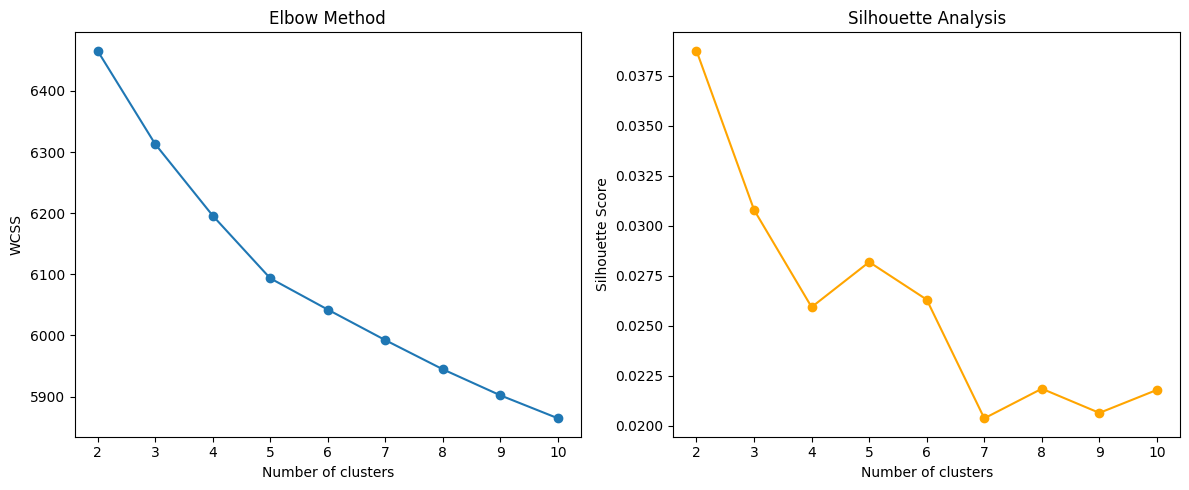

Optimal number of clusters determined: 2

Recommended Research Papers:
                                  id                                                                                                           title                                                                                                  authors  cosine_similarity
06fa196a-17e4-4b59-ad80-91bfa6de5e0e                                                                           Learning stochastic model discrepancy                                                                         ['Matthew Plumlee', 'Henry Lam']           0.502834
b485b7b1-ec3b-47eb-a9fc-bf38b29c3292                                        Online model regression for nonlinear time-varying manufacturing systems                                                         ['Jinwen Hu', 'Min Zhou', 'Xiang Li', 'Zhao Xu']           0.485957
7d06e985-d694-478f-b9cb-0ed0b6450460                                              Performance Evaluation of Co

In [2]:
from sklearn.model_selection import train_test_split

# 4. Split the data into training and testing sets
X_train, X_test, df_train, df_test = train_test_split(X, df, test_size=0.1, random_state=42)  # 90% train, 10% test

# 5. Determine the optimal number of clusters using the Elbow Method and Silhouette Analysis on the TRAINING data
range_n_clusters = range(2, 11)  # Testing clusters from 2 to 10
wcss = []           # Within-Cluster Sum-of-Squares for the Elbow Method
silhouette_scores = []  # For silhouette analysis

print("Determining optimal clusters:")
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Explicitly setting n_init
    cluster_labels = kmeans.fit_predict(X_train)

    # Compute the sum of squared distances to the closest cluster center (WCSS)
    wcss.append(kmeans.inertia_)

    # Compute the average silhouette score
    score = silhouette_score(X_train, cluster_labels)
    silhouette_scores.append(score)

    print(f"For n_clusters = {n_clusters}: WCSS = {kmeans.inertia_:.2f}, Silhouette Score = {score:.4f}")

# Plot the Elbow Method and Silhouette Analysis results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Automatically choose the number of clusters that gives the maximum silhouette score
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print("Optimal number of clusters determined:", optimal_clusters)

# 6. Perform K-means clustering with the optimal number of clusters on the TRAINING data
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10) # Explicitly setting n_init
kmeans.fit(X_train) # Fit on the training data
df_train['cluster'] = kmeans.predict(X_train) # Predict labels for the training data
df_test['cluster'] = kmeans.predict(X_test) # Assign test samples to clusters

# 7. Build the recommender system based on an input query
# Define the input query string
input_string = "stochastic hybrid system modeling"
input_string = input_string.lower()
input_string = input_string.replace(",", " ").replace(".", " ").replace(";", " ").replace(":", " ").replace("?", " ").replace("!", " ")
# trim spaces
input_string = " ".join(input_string.split())

# Convert the query string into USE embedding
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def get_embeddings(texts):
  """Generates USE embeddings for a list of texts."""
  return embed(texts)
input_vec = get_embeddings([input_string]).numpy()  # Convert to numpy

# Predict which cluster the input query belongs to
input_vec = input_vec.astype(np.float32)

input_cluster = kmeans.predict(input_vec)[0]

# Filter the train dataset to only the papers in the same cluster
cluster_indices = np.where(df_train['cluster'] == input_cluster)[0]
X_cluster = X_train[cluster_indices] # Use X_train

# Compute Euclidean distances from the input query vector to each paper in the same cluster
euclidean_dists = euclidean_distances(input_vec, X_cluster).flatten()

# Select the top 10 papers with the smallest Euclidean distances
# Check if there are enough papers in the cluster
if len(euclidean_dists) >= 10:
    top10_indices = np.argsort(euclidean_dists)[:10]
else:
    print("Warning: Less than 10 papers in the cluster. Returning all papers in the cluster.")
    top10_indices = np.argsort(euclidean_dists)
top10_cluster_indices = cluster_indices[top10_indices]

# Extract the recommended papers from the DataFrame
recommended_papers = df_train.iloc[top10_cluster_indices].copy() # Use df_train

# Compute the cosine similarity between the input query and each recommended paper
cos_sim = cosine_similarity(input_vec, X_train[top10_cluster_indices]).flatten() # Use X_train
recommended_papers['cosine_similarity'] = cos_sim

print("\nRecommended Research Papers:")
print(recommended_papers[['id', 'title', 'authors', 'cosine_similarity']].to_string(index=False))
print(recommended_papers[['title', 'cosine_similarity']].to_string(index=False))

# Computing cosine similarities for the recommended papers:
mean_cosine_similarity = recommended_papers['cosine_similarity'].mean()
median_cosine_similarity = recommended_papers['cosine_similarity'].median()

print(f"\nMean Cosine Similarity: {mean_cosine_similarity:.6f}")
print(f"Median Cosine Similarity: {median_cosine_similarity:.6f}")

**Implement HELPER functions**

In [3]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
from wordcloud import WordCloud

"""
Computes the mean and median of consine similarity matrix.

Parameter:
- similarity_matrix: Similarity matrix that was returned from consine_similarity calculation.

Returns:
- similarity_mean: Mean value of top 10 recommended papers' similarity score.
- similarity_median: Median value of top 10 recommended papers' similarity score.
"""
def cosine_similarity_mean_median(similarity_matrix:npt.NDArray):
    # Sort the similarity matrix in reverse order and select the top 10 data points
    top_n = 10
    top_indices = np.argsort(-similarity_matrix, axis=1)[:, :top_n]

    # Store the similarity values of all top 10 recommended papers for all test papers
    similarity_matrix_top10 = []
    for i, test_idx in enumerate(top_indices):
        similarity_row_top10 = []
        for j, train_idx in enumerate(test_idx):
            similarity_row_top10.append(similarity_matrix[i, train_idx])
        similarity_matrix_top10.append(similarity_row_top10)

    similarity_mean = np.mean(similarity_matrix_top10, axis=1)
    similarity_median = np.median(similarity_matrix_top10, axis=1)

    return similarity_mean, similarity_median

"""
Plots the Mean and Median of Cosine Similarity on Test Set

Parameters:
- similarity_mean: The output from cosine_similarity_mean_median
- similarity_median: The output from cosine_similarity_mean_median

Returns:
"""
def plot_cosine_similarity(similarity_mean:npt.NDArray, similarity_median:npt.NDArray):
    # Plot each array as a separate line
    plt.figure(figsize=(30, 5))
    plt.plot(similarity_mean, linestyle="-", label="Mean")
    plt.plot(similarity_median, linestyle="-", label="Median")
    plt.xlabel("Test Paper")
    plt.ylabel("Cosine Similiarity")
    plt.title("Mean and Median of Cosine Similarity on Test Set")
    plt.legend()
    #plt.savefig("plot.png", dpi=300, bbox_inches="tight")
    plt.show()

"""
Plots the Mean and Median of Pearson Correlation on Test Set

Parameters:
- correlation_mean: The output from cosine_similarity_mean_median
- correlation_median: The output from cosine_similarity_mean_median

Returns:
"""
def plot_pearson_correlation(correlation_mean, correlation_median):
    # Plot each array as a separate line
    plt.figure(figsize=(30, 5))
    plt.plot(correlation_mean, linestyle="-", label="Mean")
    plt.plot(correlation_median, linestyle="-", label="Median")
    plt.xlabel("Test Paper")
    plt.ylabel("Pearson Correlation")
    plt.title("Mean and Median of Pearson Correlation on Test Set")
    plt.legend()
    #plt.savefig("plot.png", dpi=300, bbox_inches="tight")
    plt.show()

"""
Computes TF-IDF representations for test papers and top 10 recommended papers.

Parameters:
- test_texts: List of strings (test papers).
- top10_texts: List of lists (each inner list contains 10 recommended papers as strings).

Returns:
- tfidf_matrix: TF-IDF matrix for all papers.
- test_vectors: TF-IDF vectors for test papers.
- top10_vectors: TF-IDF vectors for top 10 recommendations per test paper.
"""
def compute_tfidf_similarity(test_texts:list, top10_texts:list):
    # Flatten all texts to fit TF-IDF on the entire dataset
    #all_texts = test_texts + [paper for sublist in top10_texts for paper in sublist]

    # Flatten all texts to fit TF-IDF on the entire dataset
    #all_texts = list(map(str, test_texts)) + [str(paper) for sublist in top10_texts for paper in sublist]

    # Ensure inputs are lists of strings
    test_texts = list(test_texts) if isinstance(test_texts, np.ndarray) else test_texts
    top10_texts = list(top10_texts) if isinstance(top10_texts, np.ndarray) else top10_texts

    all_texts = test_texts + top10_texts  # Combine test and recommended texts

    # Ensure `all_texts` is a list of strings
    all_texts = [str(text) for text in all_texts]
    # Initialize and fit TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # Split TF-IDF matrix into test papers and recommended papers
    num_test_papers = len(test_texts)
    test_vectors = tfidf_matrix[:num_test_papers]  # First 'num_test_papers' rows
    top10_vectors = tfidf_matrix[num_test_papers:].toarray().reshape(num_test_papers, 10, -1)  # Reshape for 10 recommendations

    return tfidf_matrix, test_vectors, top10_vectors

"""
Computes Pearson’s correlation coefficient between each test paper and each of its top 10 recommended papers.

Parameters:
- test_embeddings: A numpy array of shape (num_test_papers, embedding_dim), where each row is the vector representation of a test paper.
- top10_embeddings: A numpy array of shape (num_test_papers, 10, embedding_dim), where each row contains embeddings for the top 10 recommended papers corresponding to each test paper.

Returns:
- correlation_mean: The mean Pearson correlation of the top 10 recommendations per test paper.
- correlation_median: The median Pearson correlation per test paper.
"""
def compute_pearson_correlation(test_embeddings:npt.NDArray, top10_embeddings:npt.NDArray):
    num_test_papers = test_embeddings.shape[0]

    correlation_mean = []
    correlation_median = []

    for i in range(num_test_papers):
        test_paper_vector = test_embeddings[i]  # Vector for the test paper
        top10_vectors = top10_embeddings[i]  # Vectors for the top 10 recommendations

        correlations = []
        for recommended_vector in top10_vectors:
            # Compute Pearson correlation between test paper and recommended paper
            corr, _ = pearsonr(test_paper_vector, recommended_vector)
            correlations.append(corr)

        # Compute mean and median Pearson correlation for the top 10 papers
        correlation_mean.append(np.mean(correlations))
        correlation_median.append(np.median(correlations))

    return correlation_mean, correlation_median

"""
Creates a word cloud from the top 5 recommended papers

Parameters:
- paper_ids: A list of ids of the top 5 recommended papers
- papers: The cleaned papers dataset from database_clean.csv as a pandas DataFrame

Returns:
- A word cloud plot of the top 5 recommended papers
"""

def createWCloud(paper_ids:list, papers:pd.DataFrame):
    # Concatenate into a single string
    text_list = papers.loc[
        papers["id"].isin(paper_ids), ["title", "abstract"]
    ].apply(
        lambda row: f"{row['title']} {row['abstract']}", axis=1
    ).tolist()
    cloud_text = " ".join(text_list)

    # Generate and display word cloud from top 5 paper content
    if cloud_text.strip():
        wcObj = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(cloud_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wcObj, interpolation='bilinear')
        plt.axis("off")
        plt.title("Word Cloud of Top Recommended Papers")
        plt.show()

        return wcObj


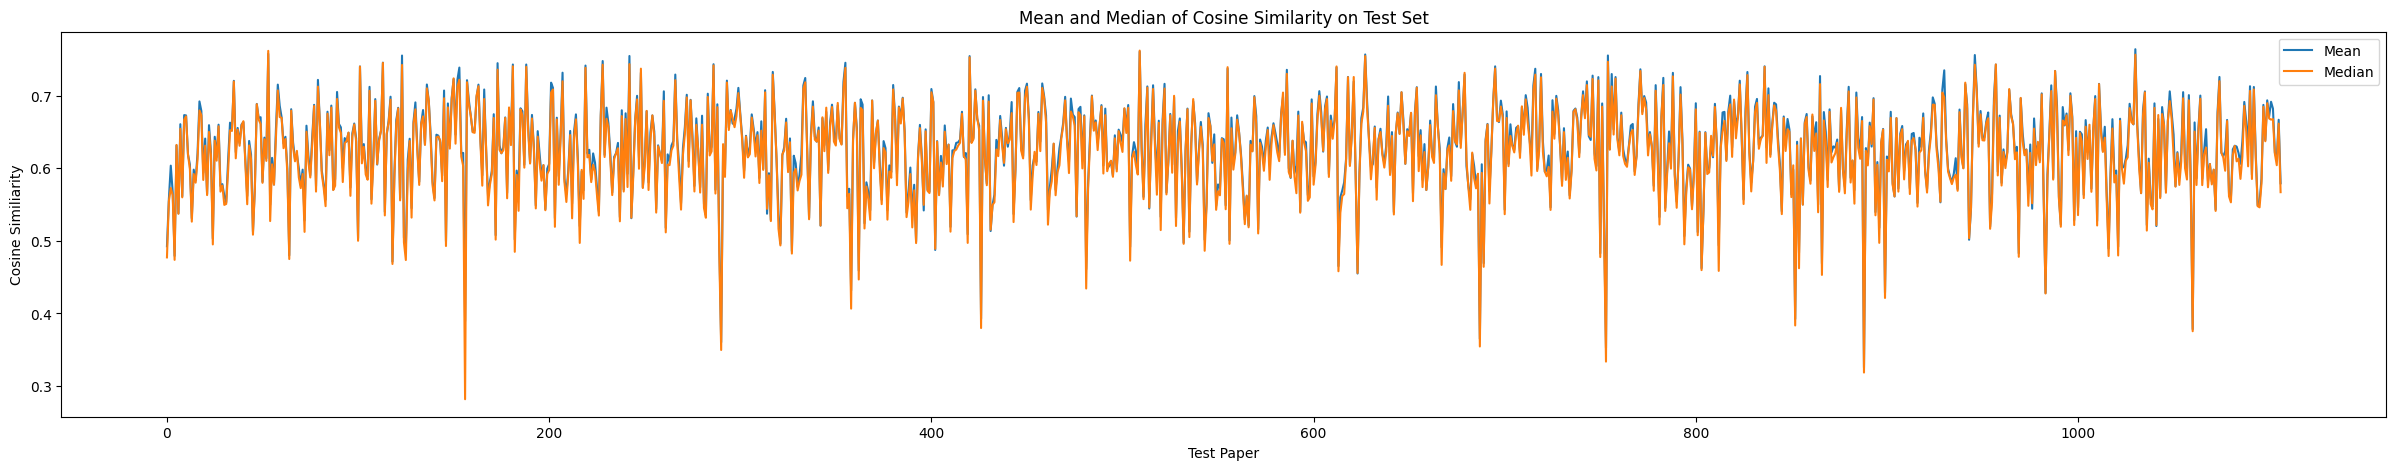

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# Store results for all test papers
top10_titles = []
top10_texts = []
top10_embeddings = []
cosine_sims = []

for i in range(len(df_test)):
    input_vec = X_test[i].reshape(1, -1)  # Test paper embedding
    input_cluster = kmeans.predict(input_vec)[0]

    # Get indices of training papers in the same cluster
    cluster_indices = np.where(df_train['cluster'] == input_cluster)[0]
    if len(cluster_indices) == 0:
        continue  # Skip if no matching cluster in train

    X_cluster = X_train[cluster_indices]

    # Compute distances and get top 10 closest
    euclidean_dists = euclidean_distances(input_vec, X_cluster).flatten()
    top10_idx = np.argsort(euclidean_dists)[:10]
    top10_cluster_indices = cluster_indices[top10_idx]

    # Save cosine similarities
    cos_sim = cosine_similarity(input_vec, X_train[top10_cluster_indices]).flatten()
    cosine_sims.append(cos_sim)

    # Save text and embeddings for later analysis
    top10_titles.append(df_train.iloc[top10_cluster_indices]['title'].tolist())
    top10_texts.append(df_train.iloc[top10_cluster_indices]['text'].tolist())
    top10_embeddings.append(X_train[top10_cluster_indices])

# Convert for similarity helpers
cosine_sim_matrix = np.array(cosine_sims)
top10_embeddings = np.array(top10_embeddings)
test_embeddings = X_test[:len(top10_embeddings)]  # Adjust in case some test items had no cluster matches

# Cosine Similarity Mean & Median
similarity_mean, similarity_median = cosine_similarity_mean_median(cosine_sim_matrix)
plot_cosine_similarity(similarity_mean, similarity_median)

# TF-IDF Similarity
test_texts = df_test.iloc[:len(top10_texts)]['text'].tolist()
tfidf_matrix, test_vectors, top10_vectors = compute_tfidf_similarity(test_texts, [text for group in top10_texts for text in group])

# Pearson Correlation
correlation_mean, correlation_median = compute_pearson_correlation(test_embeddings, top10_embeddings)

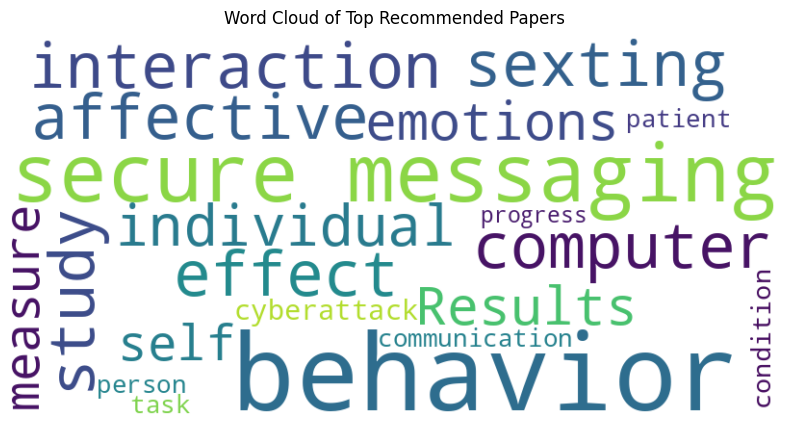

In [5]:
# Choose the test sample index (e.g., 0 for the first test paper)
test_sample_index = 0

# Get top 5 recommended paper IDs from df_train
top5_ids = df_train.iloc[
    np.where(df_train.index.isin(df_train.index[df_train['cluster'] == kmeans.predict(X_test[test_sample_index].reshape(1, -1))[0]]))[0]
][
    ['id']
].iloc[
    np.argsort(euclidean_distances(X_test[test_sample_index].reshape(1, -1), X_train[df_train['cluster'] == kmeans.predict(X_test[test_sample_index].reshape(1, -1))[0]]).reshape(-1))[:5]
].values.flatten().tolist()

# Generate word cloud
createWCloud(top5_ids, df)



Word Cloud for Test Sample 0:


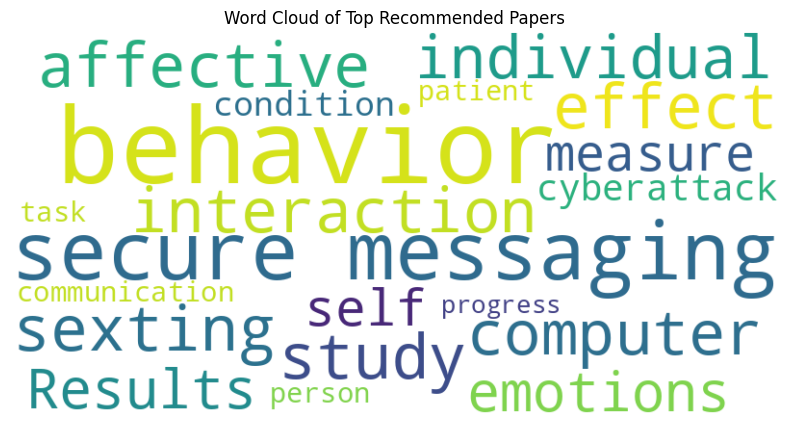


Word Cloud for Test Sample 1:


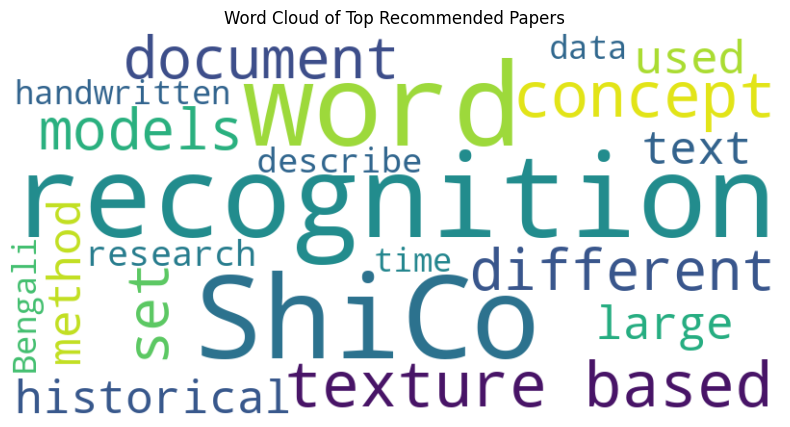


Word Cloud for Test Sample 2:


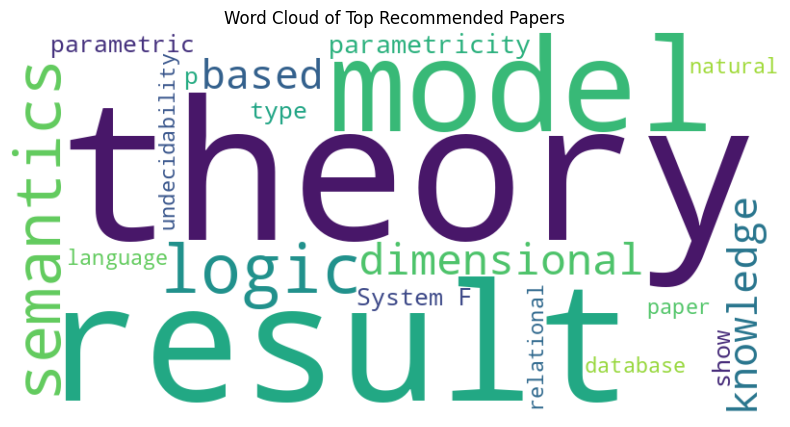

In [6]:
for i in range(3):  # Adjust the range to control how many word clouds you want
    print(f"\nWord Cloud for Test Sample {i}:")
    input_vec = X_test[i].reshape(1, -1)
    input_cluster = kmeans.predict(input_vec)[0]

    cluster_indices = np.where(df_train['cluster'] == input_cluster)[0]
    if len(cluster_indices) == 0:
        print("No cluster match found.")
        continue

    X_cluster = X_train[cluster_indices]
    dists = euclidean_distances(input_vec, X_cluster).flatten()
    top5_idx = np.argsort(dists)[:5]
    top5_cluster_indices = cluster_indices[top5_idx]
    top5_ids = df_train.iloc[top5_cluster_indices]['id'].tolist()

    createWCloud(top5_ids, df)
